# Regularized Regression Models

##### Modeling Step 4

### Notebook Summary:

#### Objective: improve the model obtained in the "poly_regression" notebook ("Modeling Step 3") with regularized models in order to decrease the feature set with different regularization levels while also not giving up accuracy results

* NB: We use the expanded dataset including ratio features filtered by RFECV
* Models used include Lasso, Ridge and Elastic Net Regression
* Each model is tuned with Nested Cross Validation i.e. using GridSearch Cross Validation to identify optimal model parameters and testing the models with Cross Validation 

#### Conclusions: 
* Strong regularization (low alphas) generally produces low validation errors   
* ##### Lasso Regression will be our newest model pick as it provides accuracy of xx with only xx features 

#### Next Steps: 
###### In the ensemble notebook we test additional modeling techniques such as Random Forest Regression to search for an even better model

In [37]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
import matplotlib.cm as cm
from yellowbrick.regressor import ResidualsPlot
%matplotlib inline

In [2]:
from sklearn import linear_model
from sklearn.metrics import r2_score, mean_squared_error,mean_absolute_error
from sklearn.model_selection import KFold,cross_val_predict,cross_val_score, cross_validate, train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, LabelBinarizer, PolynomialFeatures, MinMaxScaler, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn import preprocessing
from sklearn.neighbors import LocalOutlierFactor, KNeighborsRegressor
from sklearn.feature_selection import RFE, f_regression, RFECV
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR

In [3]:
import sys
sys.path.append('./../lib')
from airbnb_modeling import detect_feature_importance, scale_data, normalize_data, eval_metrics, plot_residuals, plot_predictions
from parse_methods import parse_columns
from airbnb_modeling import detect_interactions, add_interactions, map_variable, plot_rmse_instances,plot_rmse_features, plot_accuracy_instances

/Users/pauldefusco/anaconda2/envs/py27/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [4]:
%store -r scores_lin 
%store -r scores_tree 
%store -r scores_sv_reg 
%store -r scores_neigh_reg

In [5]:
%store -r best_model_svr 
%store -r best_model_kneigh 
%store -r best_model_dtree 
%store -r lin_reg

In [6]:
%store -r X_ratios
%store -r X_normed
%store -r X_test
%store -r y_normed
%store -r y_test

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X_ratios, y_normed, test_size=0.3, random_state=42)

In [8]:
lasso = linear_model.Lasso()

In [9]:
alphas = np.logspace(-8, -0.5, 30)
param_grid = [{'alpha': alphas},]
n_folds = 8

In [10]:
gs = GridSearchCV(lasso, param_grid, cv=n_folds,scoring='neg_mean_squared_error')

In [11]:
gs.fit(X_train, y_train)

/Users/pauldefusco/anaconda2/envs/py27/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


GridSearchCV(cv=8, error_score='raise',
       estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'alpha': array([1.00000e-08, 1.81393e-08, 3.29034e-08, 5.96846e-08, 1.08264e-07,
       1.96383e-07, 3.56225e-07, 6.46167e-07, 1.17210e-06, 2.12611e-06,
       3.85662e-06, 6.99564e-06, 1.26896e-05, 2.30181e-05, 4.17532e-05,
       7.57374e-05, 1.37382e-04, 2.49202e-04, 4.52035e-04, 8.19961e-04,
       1.48735e-03, 2.69795e-03, 4.89390e-03, 8.87720e-03, 1.61026e-02,
       2.92090e-02, 5.29832e-02, 9.61078e-02, 1.74333e-01, 3.16228e-01])}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [12]:
train_scores_lasso = np.sqrt(-gs.cv_results_['mean_train_score'])
train_scores_std_lasso = np.sqrt(-gs.cv_results_['std_train_score'])
val_scores_lasso = np.sqrt(-gs.cv_results_['mean_test_score'])
val_scores_std_lasso = np.sqrt(-gs.cv_results_['std_test_score'])

/Users/pauldefusco/anaconda2/envs/py27/lib/python2.7/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/pauldefusco/anaconda2/envs/py27/lib/python2.7/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('std_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/pauldefusco/anaconda2/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in sqrt
  
/Users/pauldefusco/anaconda2/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in sqrt
  after removing the cwd from sys.path.


(1e-08, 0.31622776601683794)

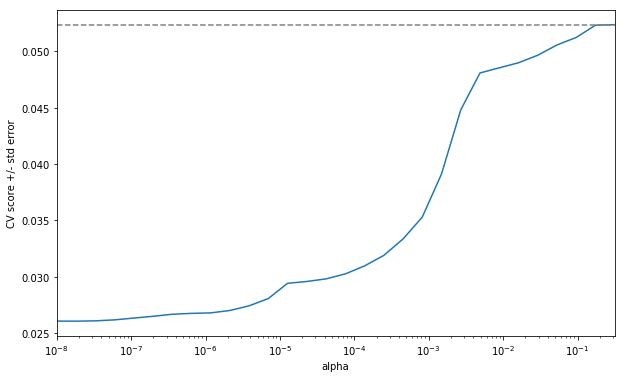

In [13]:
plt.figure().set_size_inches(10, 6)
plt.semilogx(alphas, val_scores_lasso)

# plot error lines showing +/- std. errors of the scores
std_error = val_scores_std_lasso / np.sqrt(n_folds)

plt.semilogx(alphas, val_scores_lasso + std_error, 'b--')
plt.semilogx(alphas, val_scores_lasso - std_error, 'b--')

# alpha=0.2 controls the translucency of the fill color
plt.fill_between(alphas, val_scores_lasso + std_error, val_scores_lasso - std_error, alpha=0.2)

plt.ylabel('CV score +/- std error')
plt.xlabel('alpha')
plt.axhline(np.max(val_scores_lasso), linestyle='--', color='.5')
plt.xlim([alphas[0], alphas[-1]])

In [14]:
gs.best_params_

{'alpha': 1.8139306939110633e-08}

In [15]:
best_model_lasso = gs.best_estimator_

In [16]:
#Comparing Model Coefficients by using best model parameters obtained above

In [17]:
coefs = []
for a in alphas:
    lasso = linear_model.Lasso(alpha=a, fit_intercept=False)
    lasso.fit(X_train, y_train)
    coefs.append(lasso.coef_)

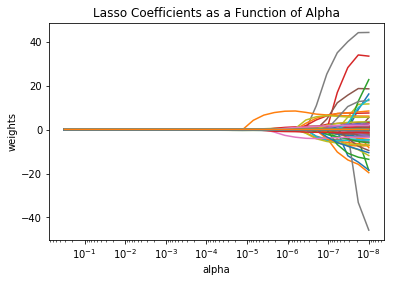

In [18]:
ax = plt.gca()

ax.plot(alphas, coefs)
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.xlabel('alpha')
plt.ylabel('weights')
plt.title('Lasso Coefficients as a Function of Alpha')
plt.axis('tight')
plt.show()

In [19]:
test_predictions_lasso = best_model_lasso.predict(X_test)

In [20]:
map_variable(y_test-test_predictions_lasso, listings)

NameError: name 'listings' is not defined

In [21]:
print 'Test R2: ',r2_score(y_test, test_predictions_lasso)
print 'Test RMSE: ',np.sqrt(mean_squared_error(y_test, test_predictions_lasso))
print 'Test MAE: ',mean_absolute_error(y_test, test_predictions_lasso)

Test R2:  0.8395656336809412
Test RMSE:  0.02518706610724885
Test MAE:  0.019380562121367982


In [22]:
feats = {} # a dict to hold feature_name: feature_importance
for feature, importance in zip(X_train.columns, np.abs(best_model_lasso.coef_)):
    feats[feature] = importance #add the name/value pair 

importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Lasso_Coef'})
importances = importances.sort_values(by='Lasso_Coef', ascending=False)

In [23]:
print "Number of Nonzero coefficients: ", len(importances[importances['Lasso_Coef']>0])

Number of Nonzero coefficients:  334


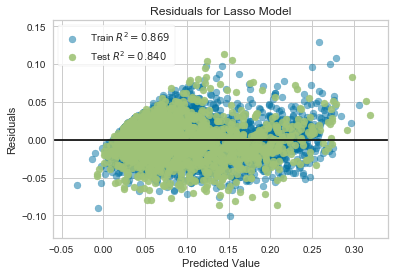

In [38]:
visualizer = ResidualsPlot(best_model_lasso)

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
g = visualizer.poof()

Now trying Ridge:

In [25]:
ridge = linear_model.Ridge()

In [26]:
alphas = np.logspace(-8, -0.5, 30)
param_grid = [{'alpha': alphas},]
n_folds = 8

In [27]:
gs = GridSearchCV(ridge, param_grid, cv=n_folds,scoring='neg_mean_squared_error')

In [28]:
gs.fit(X_train, y_train)

/Users/pauldefusco/anaconda2/envs/py27/lib/python2.7/site-packages/sklearn/linear_model/ridge.py:112: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number2.575134e-22
  overwrite_a=True).T
/Users/pauldefusco/anaconda2/envs/py27/lib/python2.7/site-packages/sklearn/linear_model/ridge.py:112: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number2.400156e-22
  overwrite_a=True).T
/Users/pauldefusco/anaconda2/envs/py27/lib/python2.7/site-packages/sklearn/linear_model/ridge.py:112: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number2.548793e-22
  overwrite_a=True).T
/Users/pauldefusco/anaconda2/envs/py27/lib/python2.7/site-packages/sklearn/linear_model/ridge.py:112: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not g

/Users/pauldefusco/anaconda2/envs/py27/lib/python2.7/site-packages/sklearn/linear_model/ridge.py:112: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number1.364713e-21
  overwrite_a=True).T
/Users/pauldefusco/anaconda2/envs/py27/lib/python2.7/site-packages/sklearn/linear_model/ridge.py:112: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number2.548125e-21
  overwrite_a=True).T
/Users/pauldefusco/anaconda2/envs/py27/lib/python2.7/site-packages/sklearn/linear_model/ridge.py:112: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number2.598497e-21
  overwrite_a=True).T
/Users/pauldefusco/anaconda2/envs/py27/lib/python2.7/site-packages/sklearn/linear_model/ridge.py:112: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not g

/Users/pauldefusco/anaconda2/envs/py27/lib/python2.7/site-packages/sklearn/linear_model/ridge.py:112: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number1.421341e-20
  overwrite_a=True).T
/Users/pauldefusco/anaconda2/envs/py27/lib/python2.7/site-packages/sklearn/linear_model/ridge.py:112: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number2.218562e-20
  overwrite_a=True).T
/Users/pauldefusco/anaconda2/envs/py27/lib/python2.7/site-packages/sklearn/linear_model/ridge.py:112: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number2.389450e-20
  overwrite_a=True).T
/Users/pauldefusco/anaconda2/envs/py27/lib/python2.7/site-packages/sklearn/linear_model/ridge.py:112: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not g

/Users/pauldefusco/anaconda2/envs/py27/lib/python2.7/site-packages/sklearn/linear_model/ridge.py:112: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number1.025537e-19
  overwrite_a=True).T
/Users/pauldefusco/anaconda2/envs/py27/lib/python2.7/site-packages/sklearn/linear_model/ridge.py:112: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number1.825822e-19
  overwrite_a=True).T
/Users/pauldefusco/anaconda2/envs/py27/lib/python2.7/site-packages/sklearn/linear_model/ridge.py:112: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number1.969176e-19
  overwrite_a=True).T
/Users/pauldefusco/anaconda2/envs/py27/lib/python2.7/site-packages/sklearn/linear_model/ridge.py:112: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not g

/Users/pauldefusco/anaconda2/envs/py27/lib/python2.7/site-packages/sklearn/linear_model/ridge.py:112: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number1.336487e-18
  overwrite_a=True).T
/Users/pauldefusco/anaconda2/envs/py27/lib/python2.7/site-packages/sklearn/linear_model/ridge.py:112: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number2.363012e-18
  overwrite_a=True).T
/Users/pauldefusco/anaconda2/envs/py27/lib/python2.7/site-packages/sklearn/linear_model/ridge.py:112: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number2.098043e-18
  overwrite_a=True).T
/Users/pauldefusco/anaconda2/envs/py27/lib/python2.7/site-packages/sklearn/linear_model/ridge.py:112: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not g

/Users/pauldefusco/anaconda2/envs/py27/lib/python2.7/site-packages/sklearn/linear_model/ridge.py:112: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number1.694521e-17
  overwrite_a=True).T
/Users/pauldefusco/anaconda2/envs/py27/lib/python2.7/site-packages/sklearn/linear_model/ridge.py:112: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number1.689718e-17
  overwrite_a=True).T
/Users/pauldefusco/anaconda2/envs/py27/lib/python2.7/site-packages/sklearn/linear_model/ridge.py:112: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number2.796999e-17
  overwrite_a=True).T
/Users/pauldefusco/anaconda2/envs/py27/lib/python2.7/site-packages/sklearn/linear_model/ridge.py:112: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not g

GridSearchCV(cv=8, error_score='raise',
       estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'alpha': array([1.00000e-08, 1.81393e-08, 3.29034e-08, 5.96846e-08, 1.08264e-07,
       1.96383e-07, 3.56225e-07, 6.46167e-07, 1.17210e-06, 2.12611e-06,
       3.85662e-06, 6.99564e-06, 1.26896e-05, 2.30181e-05, 4.17532e-05,
       7.57374e-05, 1.37382e-04, 2.49202e-04, 4.52035e-04, 8.19961e-04,
       1.48735e-03, 2.69795e-03, 4.89390e-03, 8.87720e-03, 1.61026e-02,
       2.92090e-02, 5.29832e-02, 9.61078e-02, 1.74333e-01, 3.16228e-01])}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [29]:
train_scores_ridge = np.sqrt(-gs.cv_results_['mean_train_score'])
train_scores_std_ridge = np.sqrt(-gs.cv_results_['std_train_score'])
val_scores_ridge = np.sqrt(-gs.cv_results_['mean_test_score'])
val_scores_std_ridge = np.sqrt(-gs.cv_results_['std_test_score'])

/Users/pauldefusco/anaconda2/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in sqrt
  
/Users/pauldefusco/anaconda2/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in sqrt
  after removing the cwd from sys.path.


(1e-08, 0.31622776601683794)

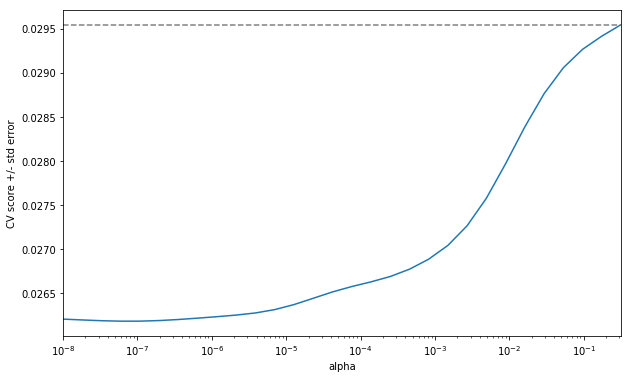

In [30]:
plt.figure().set_size_inches(10, 6)
plt.semilogx(alphas, val_scores_ridge)

# plot error lines showing +/- std. errors of the scores
std_error = val_scores_std_ridge / np.sqrt(n_folds)

plt.semilogx(alphas, val_scores_ridge + std_error, 'b--')
plt.semilogx(alphas, val_scores_ridge - std_error, 'b--')

# alpha=0.2 controls the translucency of the fill color
plt.fill_between(alphas, val_scores_ridge + std_error, val_scores_ridge - std_error, alpha=0.2)

plt.ylabel('CV score +/- std error')
plt.xlabel('alpha')
plt.axhline(np.max(val_scores_ridge), linestyle='--', color='.5')
plt.xlim([alphas[0], alphas[-1]])

In [31]:
gs.best_params_

{'alpha': 5.968456995122317e-08}

In [32]:
#Comparing Model Coefficients by using best model parameters obtained above

In [33]:
coefs = []
for a in alphas:
    ridge = linear_model.Ridge(alpha=a, fit_intercept=False)
    ridge.fit(X_train, y_train)
    coefs.append(ridge.coef_)

/Users/pauldefusco/anaconda2/envs/py27/lib/python2.7/site-packages/sklearn/linear_model/ridge.py:112: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number8.484292e-24
  overwrite_a=True).T
/Users/pauldefusco/anaconda2/envs/py27/lib/python2.7/site-packages/sklearn/linear_model/ridge.py:112: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number1.430570e-23
  overwrite_a=True).T
/Users/pauldefusco/anaconda2/envs/py27/lib/python2.7/site-packages/sklearn/linear_model/ridge.py:112: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number2.505525e-23
  overwrite_a=True).T
/Users/pauldefusco/anaconda2/envs/py27/lib/python2.7/site-packages/sklearn/linear_model/ridge.py:112: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not g

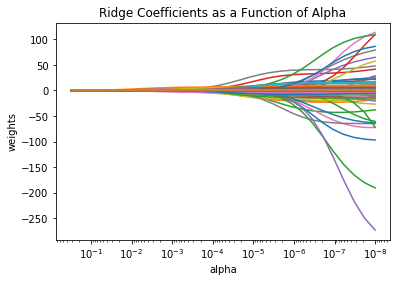

In [34]:
ax = plt.gca()

ax.plot(alphas, coefs)
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.xlabel('alpha')
plt.ylabel('weights')
plt.title('Ridge Coefficients as a Function of Alpha')
plt.axis('tight')
plt.show()

In [35]:
best_model_ridge = gs.best_estimator_
test_predictions_ridge = best_model_ridge.predict(X_test)
print 'Test R2: ',r2_score(y_test, test_predictions_ridge)
print 'Test RMSE: ',np.sqrt(mean_squared_error(y_test, test_predictions_ridge))
print 'Test MAE: ',mean_absolute_error(y_test, test_predictions_ridge)

Test R2:  0.8388284865802449
Test RMSE:  0.025244863246036583
Test MAE:  0.019433687746917283


In [36]:
map_variable(y_test-test_predictions_ridge, listings)

NameError: name 'listings' is not defined

In [39]:
feats = {} # a dict to hold feature_name: feature_importance
for feature, importance in zip(X_train.columns, np.abs(best_model_ridge.coef_)):
    feats[feature] = importance #add the name/value pair 

importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Ridge_Coef'})
importances = importances.sort_values(by='Ridge_Coef', ascending=False)

In [40]:
print "Number of Nonzero coefficients: ", len(importances[importances['Ridge_Coef']>0])

Number of Nonzero coefficients:  372


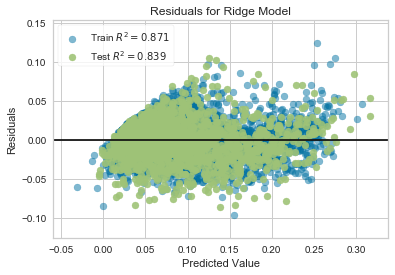

In [41]:
visualizer = ResidualsPlot(best_model_ridge)

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
g = visualizer.poof()

Now Using ElasticNet

In [42]:
en = linear_model.ElasticNet()

In [43]:
alphas = np.logspace(-8, -0.5, 30)
param_grid = [{'alpha': alphas},]
n_folds = 8

In [44]:
gs = GridSearchCV(en, param_grid, cv=n_folds,scoring='neg_mean_squared_error')

In [45]:
gs.fit(X_train, y_train)

GridSearchCV(cv=8, error_score='raise',
       estimator=ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'alpha': array([1.00000e-08, 1.81393e-08, 3.29034e-08, 5.96846e-08, 1.08264e-07,
       1.96383e-07, 3.56225e-07, 6.46167e-07, 1.17210e-06, 2.12611e-06,
       3.85662e-06, 6.99564e-06, 1.26896e-05, 2.30181e-05, 4.17532e-05,
       7.57374e-05, 1.37382e-04, 2.49202e-04, 4.52035e-04, 8.19961e-04,
       1.48735e-03, 2.69795e-03, 4.89390e-03, 8.87720e-03, 1.61026e-02,
       2.92090e-02, 5.29832e-02, 9.61078e-02, 1.74333e-01, 3.16228e-01])}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [46]:
train_scores_en = np.sqrt(-gs.cv_results_['mean_train_score'])
train_scores_std_en = np.sqrt(-gs.cv_results_['std_train_score'])
val_scores_en = np.sqrt(-gs.cv_results_['mean_test_score'])
val_scores_std_en = np.sqrt(-gs.cv_results_['std_test_score'])

/Users/pauldefusco/anaconda2/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in sqrt
  
/Users/pauldefusco/anaconda2/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in sqrt
  after removing the cwd from sys.path.


(1e-08, 0.31622776601683794)

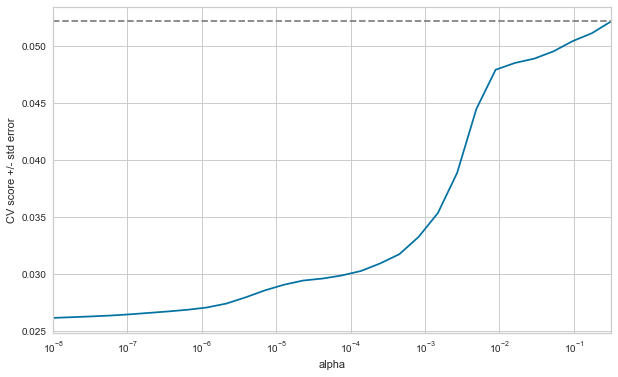

In [47]:
plt.figure().set_size_inches(10, 6)
plt.semilogx(alphas, val_scores_en)

# plot error lines showing +/- std. errors of the scores
std_error = val_scores_std_en / np.sqrt(n_folds)

plt.semilogx(alphas, val_scores_en + std_error, 'b--')
plt.semilogx(alphas, val_scores_en - std_error, 'b--')

# alpha=0.2 controls the translucency of the fill color
plt.fill_between(alphas, val_scores_en + std_error, val_scores_en - std_error, alpha=0.2)

plt.ylabel('CV score +/- std error')
plt.xlabel('alpha')
plt.axhline(np.max(val_scores_en), linestyle='--', color='.5')
plt.xlim([alphas[0], alphas[-1]])

In [48]:
gs.best_params_

{'alpha': 1e-08}

In [49]:
#Comparing Model Coefficients by using best model parameters obtained above

In [50]:
coefs = []
for a in alphas:
    ridge = linear_model.ElasticNet(alpha=a, fit_intercept=False)
    ridge.fit(X_train, y_train)
    coefs.append(ridge.coef_)

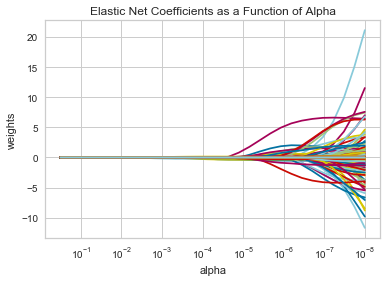

In [51]:
ax = plt.gca()

ax.plot(alphas, coefs)
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.xlabel('alpha')
plt.ylabel('weights')
plt.title('Elastic Net Coefficients as a Function of Alpha')
plt.axis('tight')
plt.show()

In [52]:
best_model_en = gs.best_estimator_
test_predictions_en = best_model_en.predict(X_test)
print 'Test R2: ',r2_score(y_test, test_predictions_en)
print 'Test RMSE: ',np.sqrt(mean_squared_error(y_test, test_predictions_en))
print 'Test MAE: ',mean_absolute_error(y_test, test_predictions_en)

Test R2:  0.8388511083998309
Test RMSE:  0.025243091516125114
Test MAE:  0.019450341161956257


In [53]:
map_variable(y_test-test_predictions_en, listings)

NameError: name 'listings' is not defined

In [ ]:
feats = {} # a dict to hold feature_name: feature_importance
for feature, importance in zip(X_train.columns, np.abs(best_model_en.coef_)):
    feats[feature] = importance #add the name/value pair 

importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'EN_Coef'})
importances = importances.sort_values(by='EN_Coef', ascending=False)

In [ ]:
print "Number of Nonzero coefficients: " ,len(importances[importances['EN_Coef']>0])

In [ ]:
visualizer = ResidualsPlot(best_model_en)

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
g = visualizer.poof()